In [1]:
!python -m pip install numpy scipy matplotlib

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csc_matrix
from scipy.optimize import linprog, milp, Bounds, LinearConstraint

# Background

See the `scipy.optimize.linprog`-based tutorial `compressed_sensing_milp_tutorial_1.ipynb` for more Compressed Sensing background. 

# Integer Linear Programming Solution

Compressed Sensing problems can be solved using SciPy's `optimize.milp` solver.  We will follow the solution strategy in [Karahanoglu et al](https://ieeexplore.ieee.org/document/6638790). The strategy in this paper does not relax the problem to the $\ell_1$ form, but directly solves the $\ell_0$ NP-hard optimization problem.

For this MILP problem, we will solve a slightly easier CS problem due to the amount of time it takes any solver to chew through an NP-hard problem.  The authors waited 100 seconds for their small toy problems, but we will make a few simplificiations that will allow the HiGHS solver to run very quickly.

The signal $x$ this time around will be a $k$-sparse binary signal (i.e., exactly $k$ ones, all other entries are zero).  The sensing matrix $A$ will be Gaussian distributed as before.

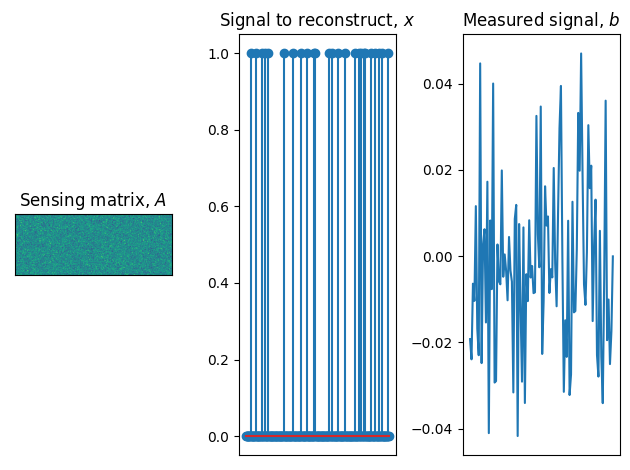

In [3]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3)

k, M, N = 25, 100, 256
cl, cu = 0, 1  # lower/upper bounds of signal, x

# generate a random measurement matrix (normal) that satisfied the RIP
A = np.random.normal(loc=0, scale=1/N, size=(M, N))

ax1.imshow(A)
ax1.set_title("Sensing matrix, $A$")
ax1.set_xticks([])
ax1.set_yticks([])

# k-sparse binary-valued signal, x
x = np.random.permutation([1.0]*k + [0.0]*(N-k))

ax2.stem(x)
ax2.set_title("Signal to reconstruct, $x$")
ax2.set_xticks([])

# simulate measurement according to A
b = A @ x

ax3.plot(b)
ax3.set_title("Measured signal, $b$")
ax3.set_xticks([])

plt.tight_layout()
plt.show()

This MILP strategy breaks the problem into two parts:
1. find the indices of the nonzero components of $x_i$
2. estimate the values $\hat{x}_i$ at those indices

To solve the first subproblem, we create binary decision variables $t_i$ such that $t_i = 1$ if $x_i$ is non-zero and, conversely, $t_i = 0$ if $x_i$ is zero.

We can recall the definition of the $\ell_0$ psuedo-norm:

$$ || x ||_0 = \sum_i x_i^0 = \sum_i (x_i \ne 0)$$

With our definition of $t_i$ and letting $z = [x, t]$, we get the equivalent cost coefficients, `c`:

$$ c z = 1^T t $$

and zeros assumed for all other coefficients.

In [4]:
c = [0]*N + [1]*N

Let's also not forget to inform the solver of the type and bounds of the decision variables.  All $t_i$ are binary (integer with lowerbound 0, upperbound 1) and $x_t$ are assumed continuous for generality (even though they are binary in this example).  We can add bounds to $x_t$ to assist the solver in reducing the feasible search space:

$$ t_i \in \{0, 1\} $$
$$ c_l \leq x_i \leq c_u $$

$c_l$ and $c_u$ are chosen such that all $x_t \in [c_l, c_u]$.  While it's an interesting problem to determine what these parameters should be, we'll leave these as empirically chosen in general and select $[0, 1]$ here because we know that $x_t$ is binary.  Incorrect choices may make the problem infeasible (if too narrow an interval) or reduce the utility of search space reduction (too wide an interval).

In [5]:
# 0 -> continuous, 1 -> integer-valued
integrality = [0]*N + [1]*N
bounds = Bounds(lb=[cl]*N + [0]*N, ub=[cu]*N + [1]*N)

With a suitable cost function and restrictions on $t_i$, the first subproblem is nearly solved.  We need one more set of constraints to ensure that nonzero elements of $x$ can only appear at the locations marked by $t$.  We can do that by introducing the inequalities:

$$ c_l t_i \leq x_i \leq c_u t_i $$

Grouping the decision variables, we get:

$$ x_i - c_u t_i \leq 0 $$
$$ -x_i + c_l t_i \leq 0 $$

or in equivalent matrix form:

$$
A_{\text{ub}} z =
\begin{bmatrix}
I & -c_uI \\
-I & Ic_l
\end{bmatrix}
\begin{bmatrix}
x \\
t
\end{bmatrix}
\leq 0 = b_{\text{ub}}
$$

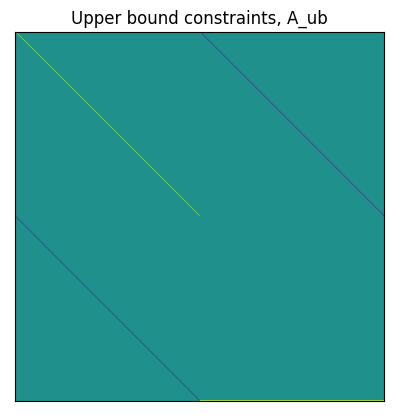

In [6]:
A_ub = np.hstack((np.eye(N), np.eye(N)*-cu))
A_ub = np.vstack((A_ub, np.hstack((np.eye(N)*-1, np.eye(N)*cl))))
A_ub = np.vstack((A_ub, [0.0]*N + [1.0]*N))
b_ub = [0.0]*(2*N) + [0.5*M]

plt.imshow(A_ub)
plt.title("Upper bound constraints, A_ub")
plt.xticks([])
plt.yticks([])
plt.show()

The second subproblem can be solved by adding the data fidelity constraints the same way we did in the linear programming example:

$$
A_{\text{ub}} z =
\begin{bmatrix}
A & 0
\end{bmatrix}
\begin{bmatrix}
x \\
t
\end{bmatrix}
= b = b_{\text{ub}}
$$

The only difference this time is that we use the `scipy.optimize.LinearConstraint` objects instead of the `A_eq` matrix:

In [7]:
A_eq = csc_matrix((M, 2*N))
A_eq[:, :N] = A
b_eq = b

constraints = [
    LinearConstraint(A=A_ub, lb=-np.inf, ub=b_ub),
    LinearConstraint(A=A_eq, lb=b_eq, ub=b_eq),
]

/venvs/tutorial/lib/python3.10/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


The paper suggests we add one more additional constraint that sets an upper limit on the sparsity of the recovered signal.  This means we want to tell the solver that we expect the number of non-zero coefficients to be less than some number.  This will hopefuly assist the solver in reducing the feasible solution space and getting to a solution faster.  The additional sparsity constraint is parametrized with $r \in (0, 1]$:

$$ || x ||_0 \leq rM $$

For many practical applications, $k$ (the $k$ in $k$-sparse) is not known a priori, however $k \ll M$ is generally a good assumption. Choosing $r = 0.5$ is a good trade-off here and can be adjusted based on particular problems:

In [8]:
r = 0.5
A_ub = [0]*N + [1]*N
b_ub = r*M
constraints.append(
    LinearConstraint(A=A_ub, lb=-np.inf, ub=b_ub)
)

With that, we are ready to solve!

Running HiGHS 1.2.2 [date: 2022-08-26, git hash: n/a]
Copyright (c) 2022 ERGO-Code under MIT licence terms
Presolving model
358 rows, 512 cols, 26624 nonzeros
357 rows, 512 cols, 26209 nonzeros
Objective function is integral with scale 1

Solving MIP model with:
   357 rows
   512 cols (256 binary, 0 integer, 0 implied int., 256 continuous)
   26209 nonzeros

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
     Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters     Time

         0       0         0   0.00%   0               inf                  inf        0      0      0         0     0.1s
 T       0       0         0   0.00%   0               25               100.00%        0      0      0       442     0.2s

Solving report
  Status            Optimal
  Primal bound      25
  Dual bound        25
  Gap               0% (tolerance: 0.01%)
  Solution status

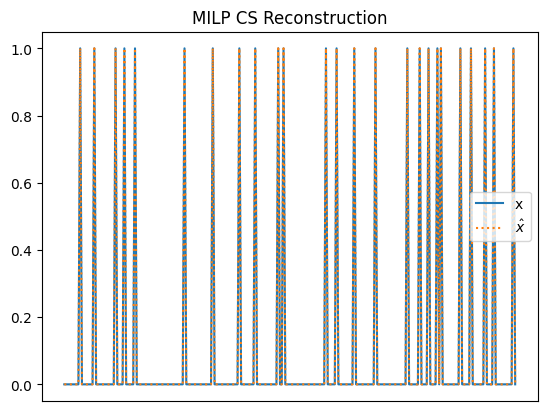

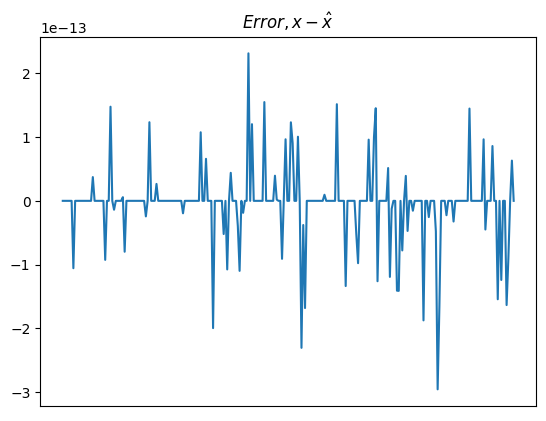

In [9]:
res = milp(c=c, integrality=integrality, bounds=bounds, constraints=constraints, options={"disp": True})
x_hat = res["x"][:N]

plt.plot(x, label="x")
plt.plot(x_hat, ":", label="$\hat{x}$")
plt.title("MILP CS Reconstruction")
plt.legend()
plt.xticks([])
plt.show()

plt.plot(x - x_hat)
plt.title("$Error, x - \hat{x}$")
plt.xticks([])
plt.show()